<a href="https://colab.research.google.com/github/casjunior93/Tera---Desafio-de-classificacao/blob/main/Refeito_Tera_Desafio_de_Classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio de Detecção e Redução de Fraudes no Setor Financeiro

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Para este trabalho, achei interessante utilizar o Ciclo de Vida Analítico, indicado pela SAS Institute (https://www.sas.com/pt_br/insights/analytics/analytics.html). Ela recomenda a segmentação da jornada analítica em passos mais detalhados e iterativos. São eles:

* Identifique o problema.
* Prepare os dados para análise.
* Explore os dados.
* Transforme os dados e crie modelos.
* Teste e valide modelos.
* Implemente modelos.
* Monitore e avalie modelos.

Aqui, seguirei os 5 primeiros passos.

# Passo 1: Identifique o problema

O desafio é propor uma solução para detecção e análise de fraudes que possam reduzir os riscos da empresa de crédito em que trabalho e garantir margens saudáveis.

Link do dataset: https://drive.google.com/file/d/1zjK8zQK5zvhR_r2chWI5dCjeOwASlPfb/view

# **Passo 2: Prepare os dados para análise**

Vou começar importando as bibliotecas iniciais:

In [2]:
%%time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Evita que o pandas apresente valores em notação científica
pd.set_option('display.float_format', lambda x: '%.5f' % x)

CPU times: user 837 ms, sys: 198 ms, total: 1.03 s
Wall time: 1.68 s


Agora importo os dados:

In [3]:
%%time
df = pd.read_csv('/content/drive/MyDrive/Tera/DESAFIO CLASSIFICAÇÃO/fraud_detection_dataset.csv')

CPU times: user 14.8 s, sys: 2.21 s, total: 17 s
Wall time: 23 s


In [4]:
%%time
df.sample(5)

CPU times: user 412 ms, sys: 3.82 ms, total: 416 ms
Wall time: 415 ms


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2578727,207,PAYMENT,16256.81000,C1993263065,60267.00000,44010.19000,M943448099,0.00000,0.00000,0,0
1800177,162,CASH_IN,142288.61000,C1615495351,0.00000,142288.61000,C1815757225,151118.76000,8830.15000,0,0
4892908,349,CASH_IN,5114.64000,C1918750760,204552.37000,209667.01000,C579203723,5750556.84000,5745442.20000,0,0
6248828,596,PAYMENT,10698.18000,C2111914582,495978.71000,485280.54000,M1545180337,0.00000,0.00000,0,0
6237968,594,PAYMENT,2076.36000,C1278866311,0.00000,0.00000,M1069219847,0.00000,0.00000,0,0


## Conhecendo as features deste dataset

* `step` - Passo: representa o total de horas transcorrido desde o início da simulação. Esta feature vai variar entre 1 e 744 (30 dias);

* `type` - Tipo: tipo de transação (depósito, saque, débito, pagamento e transferência);

* `amount` - Quantia: total que foi transacionado;

* `nameOrig` - ClienteOrigem: cliente que iniciou a transação

* `oldbalanceOrg` - SaldoInicialOrigem: saldo da conta de origem antes da transação;

* `newbalanceOrig` - SaldoFinalOrigem: saldo da conta de origem após a transação;

* `nameDest` - ClienteDestino: cliente de destino da transação;

* `oldbalanceDest` - SaldoInicialDestino: saldo da conta de destino antes da transação;

* `newbalanceDest` - SaldoFinalDestino: saldo da conta de destino após a transação;

* `isFraud` - ÉFraude: flag que define se a transação é fraudulenta ou não. Nesta simulação o objetivo da fraude é assumir a conta do usuário, esvaziá-la transferindo para outra conta e então sacando o dinheiro.

* `isFlaggedFraud` - SinalizadaComoFraude: automaticamente marcadas pelo banco como fraude por tentarem transferir mais de 200.000 em uma única transação.

## Renomeando as features

Primeiro vou renomear os rótulos das colunas para facilitar a análise.

In [5]:
%%time
df = df.rename(
    columns={"step":"totalHoras", "type": "tipoTransacao", "amount": "quantia",
             "nameOrig": "clienteOrigem", "oldbalanceOrg": "saldoInicialOrigem",
             "newbalanceOrig": "saldoFinalOrigem", "nameDest": "clienteDestino",
             "oldbalanceDest": "saldoInicialDestino", "newbalanceDest": "saldoFinalDestino",
             "isFraud": "ehFraude", "isFlaggedFraud": "sinalizadaComoFraude"
             })
df.head(3)

CPU times: user 267 ms, sys: 1.86 ms, total: 268 ms
Wall time: 269 ms


Análise descritiva:

In [6]:
%%time
df.describe(include='all')

CPU times: user 22.7 s, sys: 543 ms, total: 23.2 s
Wall time: 23 s


,totalHoras,tipoTransacao,quantia,clienteOrigem,saldoInicialOrigem,saldoFinalOrigem,clienteDestino,saldoInicialDestino,saldoFinalDestino,ehFraude,sinalizadaComoFraude
count,6362620.00000,6362620,6362620.00000,6362620,6362620.00000,6362620.00000,6362620,6362620.00000,6362620.00000,6362620.00000,6362620.00000
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C1902386530,NaN,NaN,C1286084959,NaN,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN,NaN
mean,243.39725,NaN,179861.90355,NaN,833883.10407,855113.66858,NaN,1100701.66652,1224996.39820,0.00129,0.00000
std,142.33197,NaN,603858.23146,NaN,2888242.67301,2924048.50297,NaN,3399180.11297,3674128.94209,0.03590,0.00159
min,1.00000,NaN,0.00000,NaN,0.00000,0.00000,NaN,0.00000,0.00000,0.00000,0.00000
25%,156.00000,NaN,13389.57000,NaN,0.00000,0.00000,NaN,0.00000,0.00000,0.00000,0.00000
50%,239.00000,NaN,74871.94000,NaN,14208.00000,0.00000,NaN,132705.66500,214661.44000,0.00000,0.00000
75%,335.00000,NaN,208721.47750,NaN,107315.17500,144258.41000,NaN,943036.70750,1111909.25000,0.00000,0.00000


Informações:
* Tenho 5 tipos de transação e o tipoTransacao mais frequente é CASH_OUT, com 2237500 transações.
* O cliente destino C1286084959 recebeu 113 transações no período.

Verificando a distribuição dos dados para analisar se são simétricos:

In [7]:
%%time
df.skew()

CPU times: user 1.55 s, sys: 110 ms, total: 1.66 s
Wall time: 1.65 s


totalHoras               0.37518
quantia                 30.99395
saldoInicialOrigem       5.24914
saldoFinalOrigem         5.17688
saldoInicialDestino     19.92176
saldoFinalDestino       19.35230
ehFraude                27.77954
sinalizadaComoFraude   630.60363
dtype: float64

A análise de assimetria indica que as variáveis apresentam uma assimetria positiva, ou seja, elas contém mais valores acima da média. 

Mais informações sobre os dados:

In [8]:
%%time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   totalHoras            int64  
 1   tipoTransacao         object 
 2   quantia               float64
 3   clienteOrigem         object 
 4   saldoInicialOrigem    float64
 5   saldoFinalOrigem      float64
 6   clienteDestino        object 
 7   saldoInicialDestino   float64
 8   saldoFinalDestino     float64
 9   ehFraude              int64  
 10  sinalizadaComoFraude  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
CPU times: user 14.7 ms, sys: 995 µs, total: 15.7 ms
Wall time: 25.7 ms


Tem dados faltantes?

In [9]:
%%time
df.isnull().sum()

CPU times: user 1.02 s, sys: 15.3 ms, total: 1.04 s
Wall time: 1.04 s


totalHoras              0
tipoTransacao           0
quantia                 0
clienteOrigem           0
saldoInicialOrigem      0
saldoFinalOrigem        0
clienteDestino          0
saldoInicialDestino     0
saldoFinalDestino       0
ehFraude                0
sinalizadaComoFraude    0
dtype: int64

Não existem dados faltantes.

Excluindo dados duplicados:

In [10]:
%%time
df.drop_duplicates(keep=False, inplace=True)

CPU times: user 18.4 s, sys: 353 ms, total: 18.7 s
Wall time: 18.6 s


# **Passo 3: Explore os dados**

* Visualizando alguns dados:

In [11]:
%%time
df.sample(3)

CPU times: user 396 ms, sys: 2.04 ms, total: 398 ms
Wall time: 403 ms


,totalHoras,tipoTransacao,quantia,clienteOrigem,saldoInicialOrigem,saldoFinalOrigem,clienteDestino,saldoInicialDestino,saldoFinalDestino,ehFraude,sinalizadaComoFraude
3011794,232,PAYMENT,8381.29000,C2115225472,0.00000,0.00000,M620600240,0.00000,0.00000,0,0
1466750,140,CASH_IN,193312.30000,C387324782,103241.00000,296553.30000,C445927907,0.00000,0.00000,0,0
2739276,212,TRANSFER,1217057.04000,C623988332,0.00000,0.00000,C1262738276,1294644.82000,2511701.86000,0,0


* Explorando a feature tipoTransacao:

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: tipoTransacao, dtype: int64
CPU times: user 4.31 s, sys: 91.1 ms, total: 4.4 s
Wall time: 4.39 s


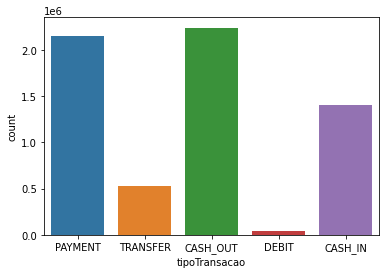

In [12]:
%%time
sns.countplot(x="tipoTransacao", data=df)
print(df.tipoTransacao.value_counts())

* Explorando a feature ehFraude:

0    6354407
1       8213
Name: ehFraude, dtype: int64
CPU times: user 571 ms, sys: 45.1 ms, total: 616 ms
Wall time: 624 ms


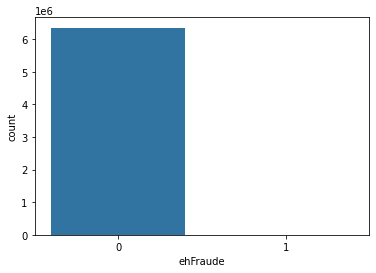

In [13]:
%%time
sns.countplot(x="ehFraude", data=df)
print(df.ehFraude.value_counts())

Há um grande desbalanceamento nos valores da feature ehFraude.

* Explorando a feature sinalizadaComoFraude:

0    6362604
1         16
Name: sinalizadaComoFraude, dtype: int64
CPU times: user 574 ms, sys: 42 ms, total: 616 ms
Wall time: 618 ms


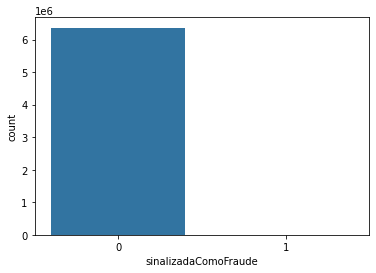

In [14]:
%%time
sns.countplot(x="sinalizadaComoFraude", data=df)
print(df.sinalizadaComoFraude.value_counts())

Também há um grande desbalanceamento entre os valores da feature sinalizadaComoFraude.